#Прогин балки.

$\cfrac{d^4w}{dx^4}=\cfrac{q}{EI}$

##Защемлення


![picture](https://drive.google.com/uc?id=1tN6JMHRoUw5I3UGxmc1F5BGfmQnnUmYC)


Граничні умови

$w(0)=0,$
$\cfrac{dw}{dx}(0)=0$

Розв'язок

$w=-\cfrac{q}{24EI}\left( x^4 - 4Lx^3 + 6L^2x^2 \right)$

$w_{max}=\cfrac{-q_0L^4}{8EI}$


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
L = 2.0
q = 1.0
G = 2.77 * 10**4
nu = 0.3
E = 2*G*(1+nu)
h = 0.5
I = (h**4)/12
print(I)

0.005208333333333333


In [ ]:
def w(x, q, E, I):
    return q/(24*E*I)*(x**4 - 4*L*x**3 + 6*L**2*x**2)

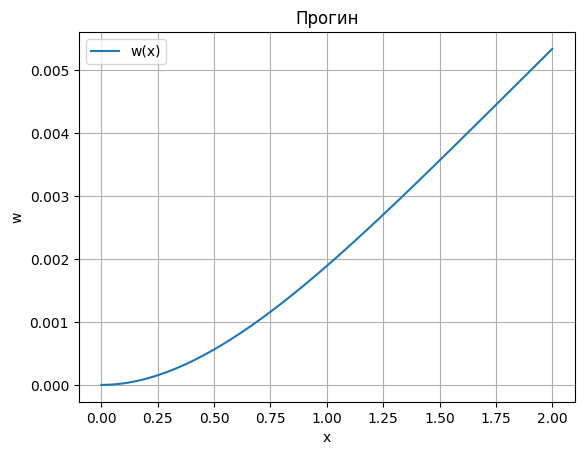

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Генерація значень x в діапазоні від -10 до 10
x_values = np.linspace(0, L, 100)

# Обчислення значень y за допомогою функції
y_values = w(x_values, q, E, I)

# Побудова графіка
plt.plot(x_values, y_values, label='w(x)')
plt.title('Прогин')
plt.xlabel('x')
plt.ylabel('w')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
w(L, q, E, I)

0.005331852263260205

#Розв'язок за допомогою PINN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        # def init_weights(m):
        #     if isinstance(m, nn.Linear):
        #         nn.init.xavier_uniform(m.weight)
        #         m.bias.data.fill_(0.02)
        self.net = nn.Sequential(
            nn.Linear(1,64),
            nn.Tanh(),
            # nn.Linear(64,64),
            # nn.Tanh(),
            # nn.Linear(64,64),
            # nn.ReLU(),
            nn.Linear(64,1),
            # nn.ReLU()
        )

        # self.apply(init_weights)
        self.double()
    def forward(self,x):
        return self.net(x)

In [ ]:
# x = torch.rand(10, 1, requires_grad = True)
# x

In [ ]:
# x = (0 - 2)*torch.rand(10, 1, requires_grad = True) + 2 + 0.000000000001
# x

In [ ]:
def initial_condition():
    return torch.tensor([0.0])

def boundary_condition():
    return torch.tensor([0.0])

In [ ]:
def generate_training_data(num_points, L):
    # x = torch.rand(num_points, 1, requires_grad = True)

    # x_rand = (0 - R)*torch.rand(int(num_points), 1, requires_grad = True) + R + 0.0001

    # x_vals = torch.linspace(0+0.001, R-0.001, num_points, requires_grad = True)
    # x_vals = x_vals + x_rand.flatten()
    # x = torch.stack([x_vals.double()], dim=1)


    # x = (0 - L)*torch.rand(int(num_points), 1, requires_grad = True) + L

    x_vals = torch.linspace(0, L, num_points, requires_grad = True)
    x = torch.stack([x_vals.double()], dim=1)


    return x

In [ ]:
tmp = torch.tensor([0.4])
tmp.view(-1,1)

tensor([[0.4000]])

In [ ]:
def generate_boundary_points(b_point):
    x_boundary = torch.tensor([b_point],  requires_grad = True)


    return x_boundary.view(-1,1)


def generate_boundary_training_data(b_point):
    x_boundary = generate_boundary_points(b_point)


    return x_boundary

In [ ]:
def pde(x, model):

    x = x.double()

    # print('*********************************************************')
    # print(x.size())
    # print(x.dtype)

    input_data = x

    # print('*********************************************************')
    # print(input_data.size())
    # print(input_data.dtype)

    u = model(input_data)
    u_x = torch.autograd.grad(u, x, grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs= torch.ones_like(u_x), create_graph= True, retain_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs= torch.ones_like(u_xx), create_graph= True, retain_graph=True)[0]
    u_xxxx = torch.autograd.grad(u_xxx, x, grad_outputs= torch.ones_like(u_xxx), create_graph= True, retain_graph=True)[0]
    # print('*********************************************************')
    # print(u_x.size())
    # print(u_x.dtype)
    # print('*********************************************************')
    # print(u.size())
    # print(u.dtype)
    # print('*********************************************************')
    # print(x.size())
    # print(x.dtype)

    eq_residual = u_xxxx
    return eq_residual

In [ ]:
def train_PINN(model, num_iterations, num_points, q, L, E, I):


    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # optimizer = optim.SGD(model.parameters(), lr=1e-3)
    # optimizer = optim.LBFGS(model.parameters())
    # breakpoint()
    # x = generate_training_data(num_points, R)
    for  iteration in range(num_iterations):
        optimizer.zero_grad()

        # breakpoint()

        x = generate_training_data(num_points, L)

        # print('generate_training_data')
        # print(x)
        # breakpoint()


        x_b = generate_boundary_training_data(L)


        # print('generate_boundary_training_data')
        # print(x_b)
        # breakpoint()

        x_initial = torch.tensor([0.0],  requires_grad = True)
        x_initial = x_initial.view(-1,1)
        x_initial = x_initial.double()

        # print('x_initial')
        # print(x_initial)
        # breakpoint()

        u_initial_x = initial_condition()
        u_initial_x = u_initial_x.double()

        # print('u_initial_x')
        # print(u_initial_x)
        # breakpoint()


        u_boundary_x = boundary_condition()

        # print('boundary_condition')
        # print(u_boundary_x)
        # breakpoint()

        residual = pde(x, model)

        # print('residual')
        # print(residual)
        # breakpoint()

        u_boundary_x = u_boundary_x.double()
        x_b = x_b.double()

        ub = model(x_b)
        ui = model(x_initial)

        ub_x = torch.autograd.grad(ub, x_b, grad_outputs= torch.ones_like(ub), create_graph= True, retain_graph=True)[0]
        ub_xx = torch.autograd.grad(ub_x, x_b, grad_outputs= torch.ones_like(ub_x), create_graph= True, retain_graph=True)[0]
        ub_xxx = torch.autograd.grad(ub_xx, x_b, grad_outputs= torch.ones_like(ub_xx), create_graph= True, retain_graph=True)[0]

        ui_x = torch.autograd.grad(ui, x_initial, grad_outputs= torch.ones_like(ui), create_graph= True, retain_graph=True)[0]

        # print('ub_x')
        # print(ub_x)

        # print('ui_x')
        # print(ui_x)

        # print('ui')
        # print(ui)

        # print('ub')
        # print(ub)

        # breakpoint()

        residual_r = torch.tensor([q/(E*I)]).double()

        # print('residual_r')
        # print(residual_r)
        # breakpoint()

        # loss =  nn.MSELoss()(u_boundary_x, ub) + \
        #         nn.MSELoss()(u_boundary_x, ub_x) + \
        #         nn.MSELoss()(u_initial_x, ui_x) + \
        #         nn.MSELoss()(residual, torch.zeros_like(residual))

        # loss =  nn.MSELoss()(u_boundary_x, ub) + \
        #         nn.MSELoss()(u_boundary_x, ub_x) + \
        #         nn.MSELoss()(u_boundary_x, (x_b)*ub_xx + nu*ub_x) + \
        #         nn.MSELoss()(u_initial_x, ui_x) + \
        #         nn.MSELoss()(residual, residual_r)

        loss =  nn.MSELoss()(u_boundary_x, ub_xx) + \
                nn.MSELoss()(u_boundary_x, ub_xxx) + \
                nn.MSELoss()(u_initial_x, ui_x) + \
                nn.MSELoss()(u_initial_x, ui) + \
                nn.MSELoss()(residual, residual_r)



        # l1_regularization, l2_regularization = torch.tensor(0.0), torch.tensor(0.0)
        # for param in model.parameters():
        #     l1_regularization += torch.norm(param, 1)**2
        #     l2_regularization += torch.norm(param, 2)**2

        # loss = loss + l1_regularization + l2_regularization

        # print('loss')
        # print(loss)
        # breakpoint()

        loss.backward()

        # breakpoint()

        optimizer.step()

        # breakpoint()

        if iteration % 100 == 0:
            print("itration", iteration, "loss", loss )

In [ ]:
model = PINN()
num_iterations = 20000
num_points = 100
train_PINN(model, num_iterations, num_points, q, L, E, I)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



itration 0 loss tensor(0.1464, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 100 loss tensor(0.0255, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 200 loss tensor(0.0059, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 300 loss tensor(0.0034, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 400 loss tensor(0.0023, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 500 loss tensor(0.0015, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 600 loss tensor(0.0011, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 700 loss tensor(0.0008, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 800 loss tensor(0.0006, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 900 loss tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1000 loss tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1100 loss tensor(0.0003, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1200 loss tensor(0.0003, dtype=torch.float64, grad_fn=<

In [ ]:
with torch.no_grad():
    x_vals = torch.linspace(0, L-0.00001, 50)


    input_data = torch.stack([x_vals.double()], dim=1)
    solution = model(input_data)
    sol = torch.stack([x_vals, solution.flatten()], dim=1)

    print(sol)



tensor([[0.0000e+00, 3.9037e-08],
        [4.0816e-02, 4.4178e-06],
        [8.1632e-02, 1.7328e-05],
        [1.2245e-01, 3.8418e-05],
        [1.6326e-01, 6.7345e-05],
        [2.0408e-01, 1.0377e-04],
        [2.4490e-01, 1.4737e-04],
        [2.8571e-01, 1.9781e-04],
        [3.2653e-01, 2.5478e-04],
        [3.6735e-01, 3.1798e-04],
        [4.0816e-01, 3.8710e-04],
        [4.4898e-01, 4.6185e-04],
        [4.8979e-01, 5.4195e-04],
        [5.3061e-01, 6.2712e-04],
        [5.7143e-01, 7.1709e-04],
        [6.1224e-01, 8.1160e-04],
        [6.5306e-01, 9.1038e-04],
        [6.9387e-01, 1.0132e-03],
        [7.3469e-01, 1.1198e-03],
        [7.7551e-01, 1.2300e-03],
        [8.1632e-01, 1.3435e-03],
        [8.5714e-01, 1.4601e-03],
        [8.9795e-01, 1.5797e-03],
        [9.3877e-01, 1.7019e-03],
        [9.7959e-01, 1.8266e-03],
        [1.0204e+00, 1.9537e-03],
        [1.0612e+00, 2.0828e-03],
        [1.1020e+00, 2.2140e-03],
        [1.1429e+00, 2.3469e-03],
        [1.183

In [ ]:
sol_np = sol.numpy()
np.shape(sol_np)
points = sol_np[:, 0]
points

array([0.        , 0.04081612, 0.08163224, 0.12244836, 0.16326448,
       0.20408061, 0.24489672, 0.28571284, 0.32652897, 0.36734509,
       0.40816122, 0.44897732, 0.48979345, 0.53060955, 0.57142568,
       0.6122418 , 0.65305793, 0.69387406, 0.73469019, 0.77550632,
       0.81632245, 0.85713851, 0.89795464, 0.93877077, 0.9795869 ,
       1.02040315, 1.06121922, 1.10203528, 1.14285147, 1.18366754,
       1.22448373, 1.2652998 , 1.30611598, 1.34693205, 1.38774812,
       1.42856431, 1.46938038, 1.51019657, 1.55101264, 1.59182882,
       1.63264489, 1.67346096, 1.71427715, 1.75509322, 1.7959094 ,
       1.83672547, 1.87754166, 1.91835773, 1.95917392, 1.99998999])

In [ ]:
pred_y = []
true_y = []
pred_y = sol_np[:, 1]
for x in points:
    true_y.append(w(x, q, E, I))

print(true_y)

[0.0, 4.381197426086723e-06, 1.72867862283483e-05, 3.836531046822636e-05, 6.727271324108185e-05, 0.00010367234398425637, 0.00014723492193676567, 0.0001976385994140749, 0.0002545689377566741, 0.0003177188578887169, 0.00038678869694565396, 0.00046148613457634084, 0.0005415264152478098, 0.0006266319567625355, 0.0007165328168509697, 0.0008109662675095565, 0.0009096770400988726, 0.0010124172650188166, 0.0011189464717086088, 0.0012290315886467921, 0.0013424469433512298, 0.0014589740900431485, 0.0015784024949048235, 0.0017005285146140133, 0.0018251560728350647, 0.0019520968662183828, 0.002081168684624146, 0.0022121982008026764, 0.0023450193256917976, 0.0024794722026228906, 0.002615405934584825, 0.002752675444777219, 0.0028911446507491746, 0.003030683258939741, 0.0031711695866785774, 0.0033124893614136877, 0.0034545344699971063, 0.003597205853131438, 0.0037404101878234283, 0.0038840632196545186, 0.004028086417947206, 0.004172409909280278, 0.004316971222787251, 0.004461714019549038, 0.004606591

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot

def plot_feature(true_y, pred_y, points):

    fig_prices = go.Figure()
    fig_prices.add_trace(go.Scatter(x=points, y=true_y,
                        # fill= 'tonexty',
                        mode='lines',
                        # line_color='indigo',
                        name="Точний розв'язок"))
    fig_prices.add_trace(go.Scatter(
                        x=points,
                        y=pred_y,
                        # fill='tonexty', # fill area between trace0 and trace1
                        mode='lines',
                        # line_color='red',
                        name="Наближений розв'язок"))


    fig_prices.update_layout(yaxis_title="Значення функції")
    fig_prices.update_layout(
    xaxis=dict(
        title='Точки колокації',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі X
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів-
    ),
    yaxis=dict(
        title='Значення функції',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі Y
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів
    ),
    legend=dict(
        font=dict(size=18)          # Збільшення розміру шрифту легенди
    )
)
    fig_prices.show()

    return 0

In [ ]:
plot_feature(true_y, pred_y, points)

0

In [ ]:
w(L/2, q, E, I)

0.0018883643432379895

In [ ]:
import pandas as pd
import numpy as np

# Об'єднання масивів в DataFrame та назви стовпців
df = pd.DataFrame({'True': true_y, 'Pred': np.round(pred_y, 6)})

# Вивід DataFrame
print(df)

        True      Pred
0   0.000000  0.000000
1   0.000004  0.000004
2   0.000017  0.000017
3   0.000038  0.000038
4   0.000067  0.000067
5   0.000104  0.000104
6   0.000147  0.000147
7   0.000198  0.000198
8   0.000255  0.000255
9   0.000318  0.000318
10  0.000387  0.000387
11  0.000461  0.000462
12  0.000542  0.000542
13  0.000627  0.000627
14  0.000717  0.000717
15  0.000811  0.000812
16  0.000910  0.000910
17  0.001012  0.001013
18  0.001119  0.001120
19  0.001229  0.001230
20  0.001342  0.001344
21  0.001459  0.001460
22  0.001578  0.001580
23  0.001701  0.001702
24  0.001825  0.001827
25  0.001952  0.001954
26  0.002081  0.002083
27  0.002212  0.002214
28  0.002345  0.002347
29  0.002479  0.002481
30  0.002615  0.002617
31  0.002753  0.002755
32  0.002891  0.002893
33  0.003031  0.003033
34  0.003171  0.003174
35  0.003312  0.003315
36  0.003455  0.003457
37  0.003597  0.003600
38  0.003740  0.003743
39  0.003884  0.003887
40  0.004028  0.004031
41  0.004172  0.004176
42  0.00431